# Randomized Response Algorithm

### Scenario

Suppose we would like to evaluate the proportion of students at a local university who have violated the Honor Code. There are, however, a few concerns:

* *Students are uncomfortable with sharing the truth.*

* *The results of the survey are not confidential.* Assume, for instance, that 10 people filled out the survey, and it is known that 20% of respondents put 'Yes (violated).' If you know that 8 respondents put 'No,' then the remaining two people must have put 'Yes.' (Such a concern could also happen directly if I'm not careful and release the data.)

We would therefore like to maintain sufficient accuracy in estimating the fraction of students who violated the Honor Code while affording **plausible deniability** to survey participants. We develop a **local differential privacy** model by adding random noise to individual survey responses, implemented with the following randomized response algorithm.

### Proposal

We propose the following mechanism:

<img src="http://zouds.com/public/inspirit/coin_flip_flow.png"/>

It is easy to see that this randomized algorithm correctly outputs participants' with probability 0.75.

In [1]:
import numpy as np

def randomized_response_algorithm(actual_response):
  output = None

  coin = np.random.randint(2)
  if coin==0:
    output = actual_response

  else:
    coin = np.random.randint(2)
    if coin==0:
      output = True
    if coin==1:
      output = False

  return output

In [2]:
N = 1000

for actual_response in range(2):
  sum = 0
  for i in range(N):
    sum += (randomized_response_algorithm(actual_response)==actual_response)
  print("{sum} of {N} students who responded {actual_response} were marked accurately".format(
    sum=sum, N=N, actual_response=bool(actual_response)))

764 of 1000 students who responded False were marked accurately
759 of 1000 students who responded True were marked accurately


### Using the algorithm

**Claim.**  $$\text{Pr}(\textsf{Violated}) = 2\text{Pr}(\textsf{Yes}) - 0.5,$$

where $\text{Pr}(\textsf{Violated})$ is the estimated proportion of honor code violators and $\text{Pr}(\textsf{Yes})$ is the probability that a randomized response is 'Yes.'

*Proof:* Observe that

\begin{align*}
\text{Pr}(\textsf{Yes}) &= \text{Pr}(\textsf{Yes, Violated}) + \text{Pr}(\textsf{Yes, Not Violated}) \\
&= \text{Pr}(\textsf{Yes} \mid \textsf{Violated}) \text{Pr}(\textsf{Violated}) + \text{Pr}(\textsf{Yes} \mid \textsf{Not Violated}) \text{Pr}(\textsf{Not Violated})
\end{align*}

Rearranging,

$$\text{Pr}(\textsf{Violated}) = \frac{\text{Pr}(\textsf{Yes}) - \text{Pr}(\textsf{Yes} \mid \textsf{Not Violated})}{\text{Pr}(\textsf{Yes} \mid \textsf{Violated}) - \text{Pr}(\textsf{Yes} \mid \textsf{Not Violated})}.$$

Since $\text{Pr}(\textsf{Yes} \mid \textsf{Not Violated}) = 0.25$ and $\text{Pr}(\textsf{Yes} \mid \textsf{Violated}) = 0.75$ (as verified with our above simulation),

$$\text{Pr}(\textsf{Violated}) = \frac{\text{Pr}(\textsf{Yes}) - 0.25}{0.5} = 2\text{Pr}(\textsf{Yes}) - 0.5$$

as claimed. $\blacksquare$

See line 12 below.

In [5]:
def run_survey(num_participants, actual_violated_fraction):

  num_actual_violated = int(num_participants * actual_violated_fraction)
  num_actual_not_violated = int(num_participants - num_actual_violated)
  actual_statuses = [True] * num_actual_violated \
      + [False] * num_actual_not_violated
  
  yes_responses = 0.0
  for i in range(len(actual_statuses)):
    yes_responses += randomized_response_algorithm(actual_statuses[i])
  p_yes = yes_responses/len(actual_statuses)

  return 2*p_yes - 0.5

num = 50000
frac = 0.2
p_violated = run_survey(num_participants=num, actual_violated_fraction=frac)
  
print("Actual Honor Code violator fraction:", frac)
print("Survey administrator believes Honor Code violator fraction is:",\
      round(p_violated, 3))


Actual Honor Code violator fraction: 0.2
Survey administrator believes Honor Code violator fraction is: 0.199


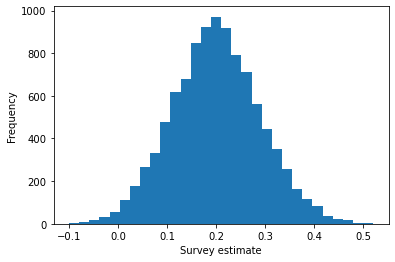

In [24]:
from matplotlib import pyplot as plt

def plot_survey(rounds,
                num_participants,
                actual_violated_fraction):

  data = np.empty([0])
  for i in range(rounds):
    data = np.append(
      data, run_survey(num_participants, actual_violated_fraction)
    )

  plt.hist(data, bins=30)
  plt.xlabel('Survey estimate')
  plt.ylabel('Frequency')
  plt.show()

plot_survey(10000, 100, 0.2)